
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [ ]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, cohen_kappa_score
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC


In [ ]:
myData = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
myData.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [ ]:
X = myData.drop(columns=["cp"])
y = myData["cp"]

In [ ]:
ct_knn = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


KNN

In [ ]:
knn_pipeline1 = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("knn", KNeighborsClassifier())
    ]
).set_output(transform="pandas")

params = {'knn__n_neighbors': list(range(1, 100))}

grid_search = GridSearchCV(
    knn_pipeline1,
    params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X, y)

best_n_neighbors = grid_search.best_params_['knn__n_neighbors']
best_accuracy = grid_search.best_score_

print(f"Best n_neighbors: {best_n_neighbors}")
print(f"Best Accuracy: {best_accuracy}")


Best n_neighbors: 56
Best Accuracy: 0.5531986531986531


In [ ]:
knn_pipeline1 = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("knn", KNeighborsClassifier(n_neighbors=56))
    ]
).set_output(transform="pandas")

In [ ]:
knn_pipeline1.fit(X, y)
y_pred_knn = knn_pipeline1.predict(X)
conf_matrix = confusion_matrix(y, y_pred_knn)

Decision Tree

In [ ]:
dt_pipeline = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("dt", DecisionTreeClassifier())
    ]
).set_output(transform="pandas")

params = {'dt__min_impurity_decrease': [0.0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

grid_search = GridSearchCV(
    dt_pipeline,
    params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X, y)

best_min_impurity_decrease = grid_search.best_params_['dt__min_impurity_decrease']
best_accuracy = grid_search.best_score_

print(f"Best min_impurity_decrease: {best_min_impurity_decrease}")
print(f"Best Accuracy: {best_accuracy}")


Best min_impurity_decrease: 0.01
Best Accuracy: 0.49845117845117837


In [ ]:
dt_pipeline = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("dt", DecisionTreeClassifier(min_impurity_decrease=0.01))
    ]
).set_output(transform="pandas")


In [ ]:
dt_pipeline.fit(X, y)
y_pred_tree = dt_pipeline.predict(X)
conf_matrix = confusion_matrix(y, y_pred_tree)

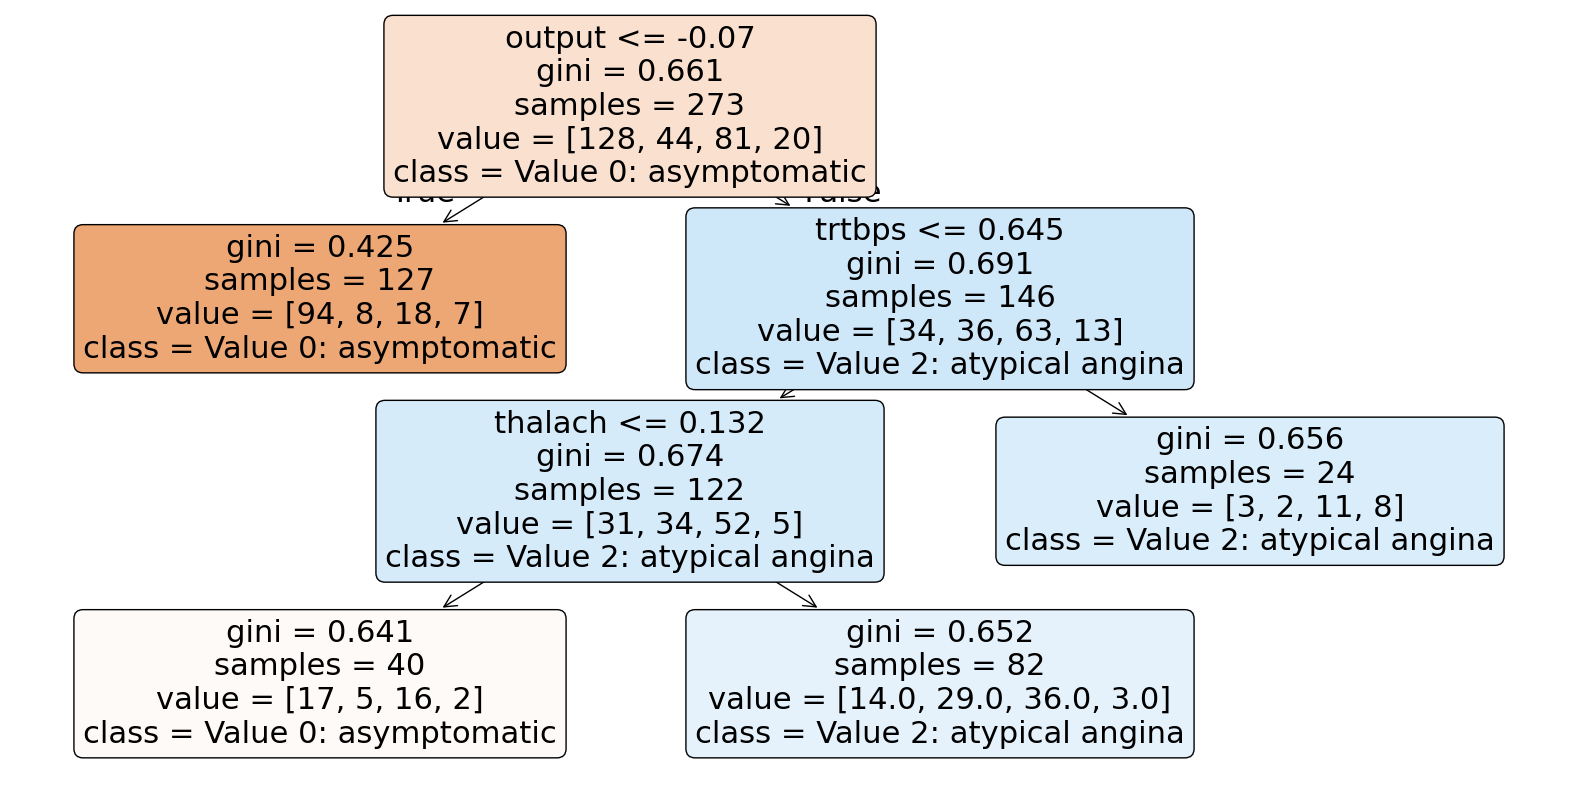

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(dt_pipeline.named_steps['dt'], filled=True, feature_names=X.columns, class_names=["Value 0: asymptomatic", "Value 1: typical angina", "Value 2: atypical angina", "Value 3: non-anginal pain"], rounded=True)
plt.show()

When predicting chest pain logically output was the most important, which is wether or not they are at risk for a heart attack. The next most important is resting blood pressure, followed by maximum heart rate during exercise.

LDA

In [ ]:
lda_pipeline = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("lda", LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'))
    ]
).set_output(transform="pandas")

lda_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a74e91450f0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a74e9147a60>)])),
                ('lda',
                 LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'))])

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [ ]:
myData["Cp_is_0"] = (myData["cp"] == 0).astype('bool')
myData["Cp_is_1"] = (myData["cp"] == 1).astype('bool')
myData["Cp_is_2"] = (myData["cp"] == 2).astype('bool')
myData["Cp_is_3"] = (myData["cp"] == 3).astype('bool')
myData

,age,sex,cp,trtbps,chol,restecg,thalach,output,Cp_is_0,Cp_is_1,Cp_is_2,Cp_is_3
0,63,1,3,145,233,0,150,1,False,False,False,True
1,37,1,2,130,250,1,187,1,False,False,True,False
2,56,1,1,120,236,1,178,1,False,True,False,False
3,57,0,0,120,354,1,163,1,True,False,False,False
4,57,1,0,140,192,1,148,1,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0,True,False,False,False
269,57,0,0,140,241,1,123,0,True,False,False,False
270,45,1,3,110,264,1,132,0,False,False,False,True
271,68,1,0,144,193,1,141,0,True,False,False,False


In [ ]:
y0 = myData["Cp_is_0"]
y1 = myData["Cp_is_1"]
y2 = myData["Cp_is_2"]
y3 = myData["Cp_is_3"]
Xn = myData.drop(columns=["cp", "Cp_is_0","Cp_is_1","Cp_is_2","Cp_is_3" ])

In [ ]:
log_pipeline = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("logreg", LogisticRegression())
    ]
).set_output(transform="pandas")



In [ ]:
log_pipeline.fit(Xn, y0)
y_pred0 = log_pipeline.predict(X)
f0 = f1_score(y0, y_pred0, average='binary')

In [ ]:
log_pipeline.fit(Xn, y1)
y_pred1 = log_pipeline.predict(X)
f1 = f1_score(y1, y_pred1, average='binary')

In [ ]:
log_pipeline.fit(Xn, y2)
y_pred2 = log_pipeline.predict(X)
f2 = f1_score(y2, y_pred2, average='binary')

In [ ]:
log_pipeline.fit(Xn, y3)
y_pred3 = log_pipeline.predict(X)
f3 = f1_score(y3, y_pred3, average='binary')

In [ ]:
f0, f1, f2, f3

(0.7286821705426356, 0.0, 0.20408163265306123, 0.0)

The CP with 0 category was best using OvR with a f1 score of 0.7286

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [ ]:
Data = myData.drop(columns=["Cp_is_0",	"Cp_is_1",	"Cp_is_2",	"Cp_is_3"])
Data1 = Data[(myData["cp"] == 0) | (myData["cp"] == 1)]
Data2 = Data[(myData["cp"] == 0) | (myData["cp"] == 2)]
Data3 = Data[(myData["cp"] == 0) | (myData["cp"] == 3)]


X1 = Data1.drop(columns=["cp"])
y1 = Data1["cp"]
X2 = Data2.drop(columns=["cp"])
y2 = Data2["cp"]
X3 = Data3.drop(columns=["cp"])
y3 = Data3["cp"]

0 and 1

In [ ]:
log_pipeline.fit(X1, y1)
y_prob1 = log_pipeline.predict_proba(X1)[:, 1]
roc_auc1 = roc_auc_score(y1, y_prob1)

0 and 2

In [ ]:
log_pipeline.fit(X2, y2)
y_prob2 = log_pipeline.predict_proba(X2)[:, 1]
roc_auc2 = roc_auc_score(y2, y_prob2)

0 and 3

In [ ]:
log_pipeline.fit(X3, y3)
y_prob3 = log_pipeline.predict_proba(X3)[:, 1]
roc_auc3 = roc_auc_score(y3, y_prob3)

comparisons

In [ ]:
roc_auc1, roc_auc2, roc_auc3


(0.8449928977272727, 0.8074845679012346, 0.828515625)

The OvO approach was best at distinguishing the 0 and 1 pair followed by the 0 and 3 pair, and last was the 0 and 2 pair. The respecticely had roc aucs of 0.844, 0.828, and .807.